In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error
import copy

In [2]:
# Settings
figsize = (16,8) #figsize in inches. 
root = "CSV_files/"
Test1_1_txt = root + "TEST1_1_COOLED_WITHFAN.csv"
Test2_1_txt = root + "Test2_1_cooled_withoutfan.csv"
Test3_2_txt = root + "TEST3_2_withfan_nocooling_newambient.csv"
Test4_1_txt = root + "TEST4_1_withoutfan_nocooling_newambient3.csv"
Test5_1_txt = root + "TEST5_1_withfan_cooling_newambient3.csv"
Test6_1_txt = root + "TEST6_1_COOLED_NOFAN.csv"

In [73]:
# Read Files
col_select = [0,1,2,3,4,5,6,7,8,10] #dropping the Ambient_X because it was corrupted. 

#Test1_1 = pd.read_csv(Test1_1_txt, sep=';', index_col=0).replace(',','.', regex=True).convert_objects(convert_numeric=True);
#Test2_1 = pd.read_csv(Test2_1_txt, sep=';', index_col=0).replace(',','.', regex=True).convert_objects(convert_numeric=True);
Test3_2 = pd.read_csv(Test3_2_txt, sep=';', index_col=0, usecols = col_select).replace(',','.', regex=True).convert_objects(convert_numeric=True);
Test4_1 = pd.read_csv(Test4_1_txt, sep=';', index_col=0, usecols = col_select).replace(',','.', regex=True).convert_objects(convert_numeric=True);
Test5_1 = pd.read_csv(Test5_1_txt, sep=';', index_col=0, usecols = col_select).replace(',','.', regex=True).convert_objects(convert_numeric=True);
Test6_1 = pd.read_csv(Test5_1_txt, sep=';', index_col=0, usecols = col_select).replace(',','.', regex=True).convert_objects(convert_numeric=True);

# Rename

cooled_nofan = Test6_1;
cooled_fan = Test5_1;
roomtemp_fan = Test3_2;
roomtemp_nofan = Test4_1;

/home/jgrietens/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  
/home/jgrietens/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  import sys
/home/jgrietens/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  
/home/jgrietens/anaconda3/lib/python

In [74]:
#print("Test1_1.shape: ", Test1_1.shape, str(Test1_1.shape[0]/60/60) + " h ")
#print("Test2_1.shape: ", Test2_1.shape, str(Test2_1.shape[0]/60/60) + " h ")
print("Test3_2.shape: (roomtemp_fan) ", Test3_2.shape, str(Test3_2.shape[0]/60/60) + " h ")
print("Test4_1.shape: (roomtemp_nofan) ", Test4_1.shape, str(Test4_1.shape[0]/60/60) + " h ")
print("Test5_1.shape: (cooled_fan) ", Test5_1.shape, str(Test5_1.shape[0]/60/60) + " h ")
print("Test6_1.shape: (cooled_nofan) ", Test6_1.shape, str(Test5_1.shape[0]/60/60) + " h ")

Test3_2.shape: (roomtemp_fan)  (14497, 9) 4.026944444444444 h 
Test4_1.shape: (roomtemp_nofan)  (15138, 9) 4.205 h 
Test5_1.shape: (cooled_fan)  (28801, 9) 8.000277777777777 h 
Test6_1.shape: (cooled_nofan)  (28801, 9) 8.000277777777777 h 


In [102]:
#Time setting for each test

#roomtemp_fan
t_script_rf = 20                                    #seconden voor raspi cyclus begon te lopen
t_start_rf = t_script_rf
t_end_sleep_rf = t_start_rf + 1*60                  #end of the 1 minute measurement without power. 
t_end_steady_rf = t_end_sleep_rf + 2 * 60 * 60      #end of the 2h steady power
t_stop_rf = t_end_steady_rf  + 2 * 60 * 60          #end of the 2h of cycling power
#roomtemp_nofan
t_script_rnf = 20                                    #seconden voor raspi cyclus begon te lopen
t_start_rnf = t_script_rnf
t_end_sleep_rnf = t_start_rnf + 1*60                  #end of the 1 minute measurement without power. 
t_end_steady_rnf = t_end_sleep_rnf + 2 * 60 * 60      #end of the 2h steady power
t_stop_rnf = t_end_steady_rnf  + 2 * 60 * 60          #end of the 2h of cycling power
#cooled_fan
t_script_cf = 20 + 3 * 60 *60                            #20 tscript + 3h laten rusten 
t_start_cf = t_script_cf
t_end_sleep_cf = t_start_cf + 1*60                    # end of the 1 minute measurement without power. 
t_end_steady_cf = t_end_sleep_cf + 2 * 60 * 60       #end of the 2h steady power
t_stop_cf = t_end_steady_cf + 2 * 60 * 60                        #end of the 2h of cycling power
#cooled_nofan
t_script_cnf = 20  + 3 * 60 *60                                  #seconden voor raspi cyclus begon te lopen
t_start_cnf = t_script_cnf
t_end_sleep_cnf = t_start_cnf + 1*60                  #end of the 1 minute measurement without power. 
t_end_steady_cnf = t_end_sleep_cnf + 2 * 60 * 60      #end of the 2h steady power
t_stop_cnf = t_end_steady_cnf  + 2 * 60 * 60          #end of the 2h of cycling power

In [103]:
#slice based on the specific time constants
cooled_nofan_crop = cooled_nofan.iloc[t_start_cnf:t_stop_cnf]
cooled_fan_crop = cooled_fan.iloc[t_start_cf:t_stop_cf]
roomtemp_fan_crop = roomtemp_fan.iloc[t_start_rf:t_stop_rf]
roomtemp_nofan_crop = roomtemp_nofan.iloc[t_start_rnf:t_stop_rnf]



#Test3_2_full_cycle.plot(title="full cycle",figsize = figsize)
#Test3_2_sleep.plot(title="sleep",figsize = figsize)
#Test3_2_cstpower.plot(title="Cst. Power",figsize = figsize)
#Test3_2_cycledpower.plot(title="Cycled Power",figsize = figsize)

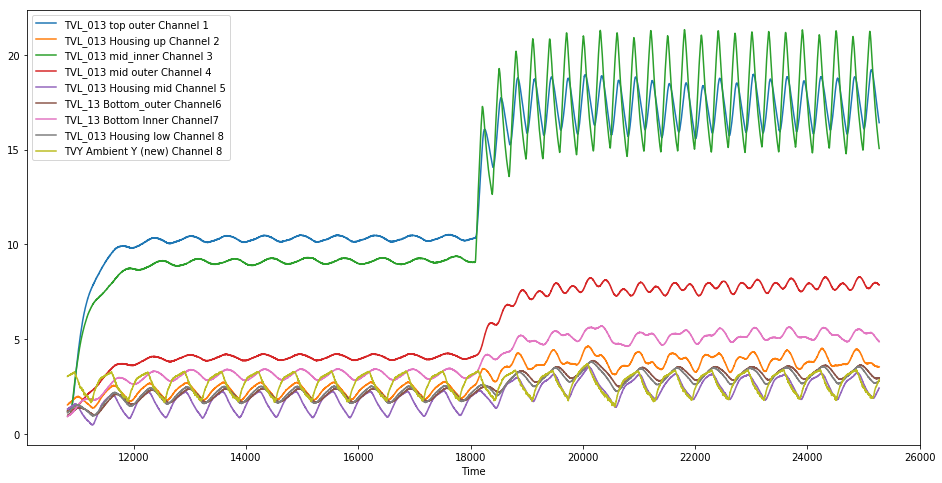

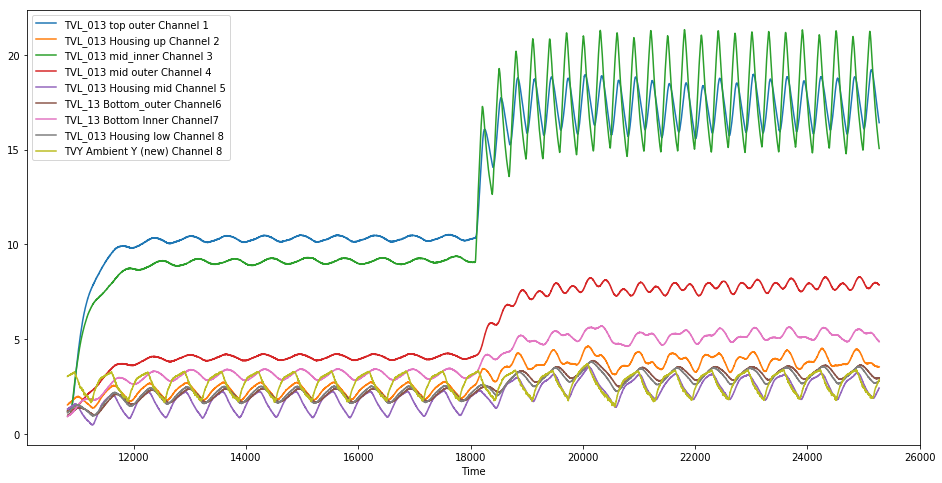

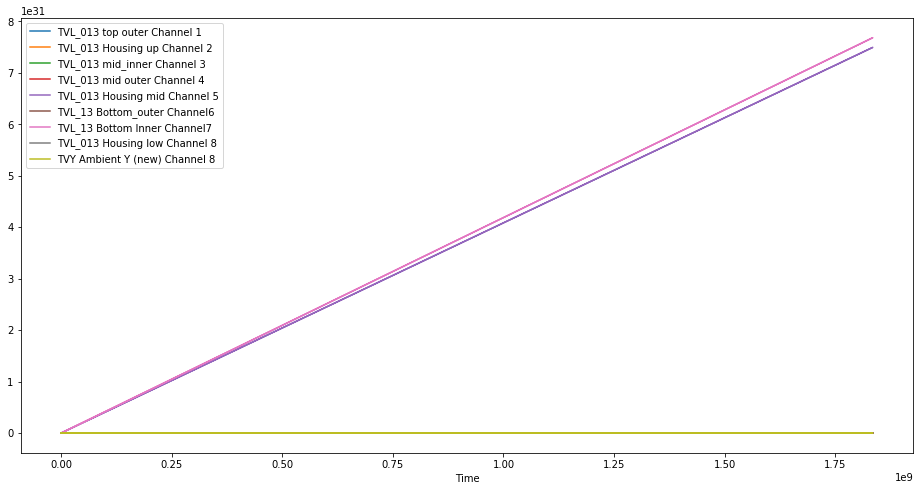

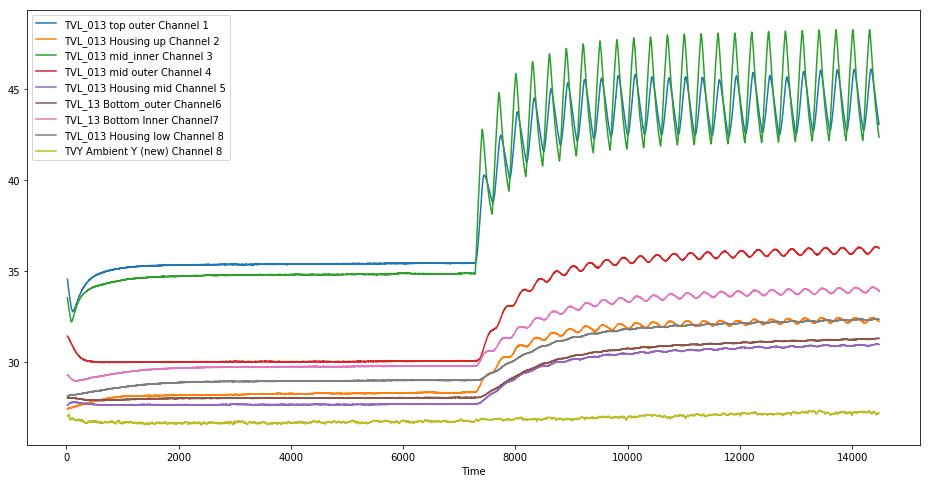

In [104]:
cooled_nofan_crop.plot(figsize=figsize) 
cooled_fan_crop.plot(figsize=figsize) 
roomtemp_fan_crop.plot(figsize=figsize)  
roomtemp_nofan_crop.plot(figsize=figsize) 

In [86]:
2000/60/60

0.5555555555555556

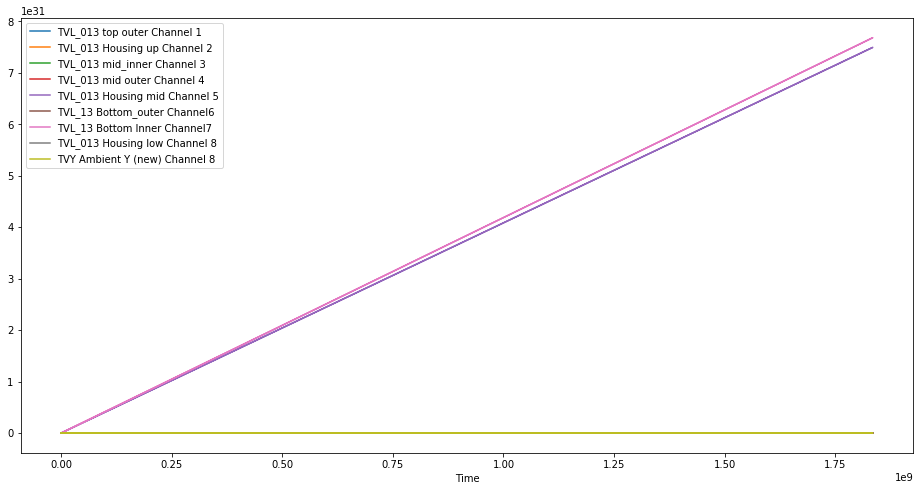

In [107]:
roomtemp_fan.plot(figsize=figsize)